# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [18]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &
Note: you may need to restart the kernel to use updated packages.


### Download the Videos

In [19]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1 -O ua_detrac.mp4
# Getting the Yolo object detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/yolo_object_detector.py

File 'ua_detrac.mp4' already there; not retrieving.
File 'yolo_object_detector.py' already there; not retrieving.



### Load the surveillance videos for analysis

##### We use regular expression to load all the videos into the table

In [20]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@query_time: 0.03936416003853083
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.07350237295031548


### Visualize Video

In [4]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Register YOLO Object Detector an an User-Defined Function (UDF) in EVA 

In [21]:
cursor.execute("""CREATE UDF IF NOT EXISTS YoloV5
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'yolo_object_detector.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                            0
0  UDF YoloV5 already exists, nothing added.
@query_time: 0.014365370385348797


### Run Object Detector on the video

In [22]:
cursor.execute("""SELECT id, YoloV5(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
     objectdetectionvideos.id  \
0                          0   
1                          1   
2                          2   
3                          3   
4                          4   
5                          5   
6                          6   
7                          7   
8                          8   
9                          9   
10                        10   
11                        11   
12                        12   
13                        13   
14                        14   
15                        15   
16                        16   
17                        17   
18                        18   
19                        19   

                                                                                          yolov5.labels  \
0   [car, car, car, car, car, car, car, car, car, person, car, motorcycle, car, truck, car, car, car...   
1   [car, car, car, car, car, car, car, car, car, person, car, car, tru

### Visualizing output of the Object Detector on the video

In [23]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolov5.bboxes', 'yolov5.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

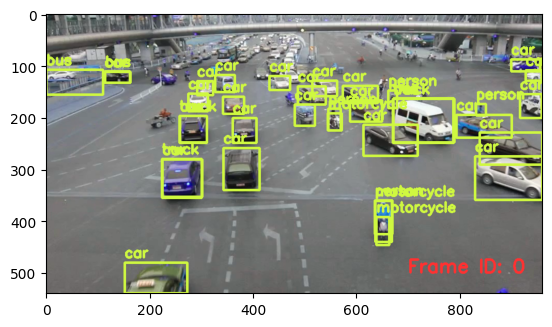

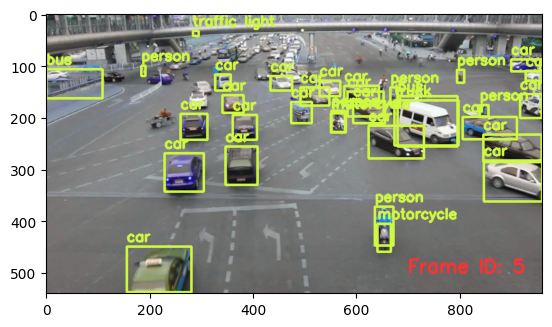

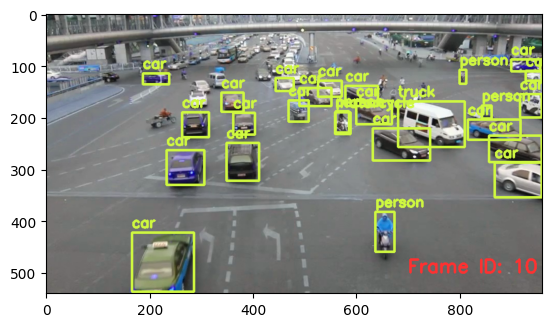

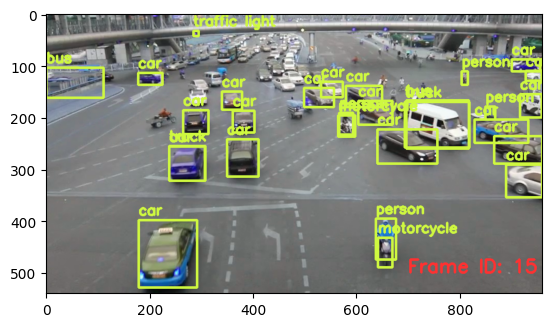

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x0c\x01N...')

In [24]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping an User-Defined Function (UDF)

In [25]:
cursor.execute("DROP UDF YoloV5;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                  0
0  UDF YoloV5 successfully dropped
@query_time: 0.019077396020293236
